# PIK3CA phosphoproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
en_object = cptac.Endometrial()
desired_cutoff = .2

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n')
endometrial_freq_mut.loc[endometrial_freq_mut['Gene'] == 'PIK3CA']

                                    

Number of Frequently Mutated Genes: 10 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
5,PIK3CA,0.494737,0.484211,0.010526


## Step 3: Select PIK3CA, a frequently mutated gene

In [3]:
gene = 'PIK3CA'

## Step 4: Select phosphoproteomics

In [4]:
omics = en_object.get_phosphoproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. The first three steps are found in the format_phospho_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

In [7]:
# Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = en_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - format for loop (only phospho)
tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [8]:
# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
omics_col_list = list(only_phospho.columns) 
sig_pval_mut_status = al.wrap_ttest(binary_phospho, 'binary_mutations', omics_col_list)
sig_pval_mut_status

Doing t-test comparison for mutation status

No significant comparisons.


In [13]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(only_phospho.columns)
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df.head()

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,PIK3CA-S312,-0.00615
1,Wildtype,PIK3CA-S312,-0.02220
2,Mutated,PIK3CA-S312,NaN
3,Wildtype,PIK3CA-S312,NaN
4,Wildtype,PIK3CA-S312,0.43600


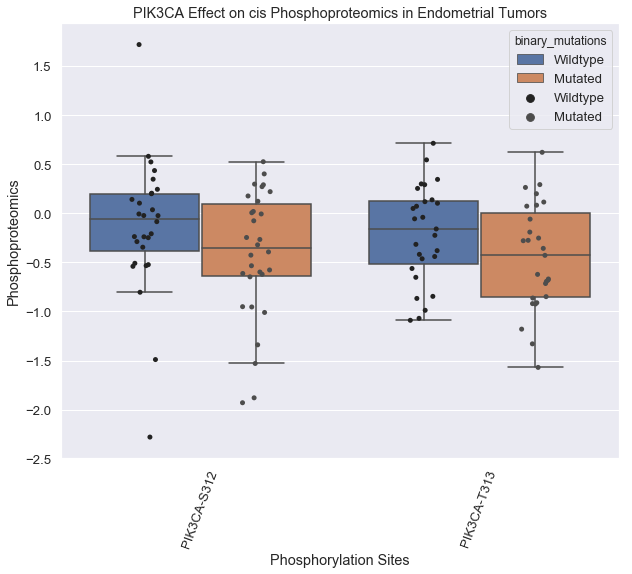

In [14]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.2)
en_cis_boxplot = sns.boxplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphoproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation=70)
plt.show()
plt.clf()
plt.close()

There is no significant difference between mutated and wildtype.

Repeat the same steps to compare mutation type (missence vs. truncation). Use the function, get_missence_truncation_comparison, to get the mutation type binary column and format the dataframe.

In [15]:
# Steps 1-3
formated_phospho_mut_type = f.get_missence_truncation_comparison(en_object, 'phosphoproteomics', gene)

In [16]:
# Step 4 - T-test comparing means of missence vs truncation effect on cis omics
print("Doing t-test comparison\n")
sig_pval_mut_type = al.wrap_ttest(formated_phospho_mut_type, 'binary_mutations', omics_col_list)
print(sig_pval_mut_type)

Doing t-test comparison

No significant comparisons.
None


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


No significant comparisons for mutation type. 

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. 

In [10]:
colon_object = cptac.Colon()
desired_cutoff = .2

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n')
colon_freq_mut.loc[colon_freq_mut['Gene'] == 'PIK3CA']

                                    

Number of Frequently Mutated Genes: 39 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
25,PIK3CA,0.247423,0.237113,0.010309


In [11]:
gene = 'PIK3CA'

co_omics = colon_object.get_phosphoproteomics()

In [12]:
omics_mutations = colon_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

Not possible to do the phosphoproteomic cis comparison for the colon dataset.

# Analysis of Results

No significant comparisons.